# Traveling Salesman Problem


Peter Norvig has an excellent [notebook](https://github.com/norvig/pytudes/blob/master/ipynb/TSP.ipynb) on the Traveling Salesman Problem (TSP), which inspired me to play around some as well.

The first part of the notebook duplicates his work, and thereafter I dabble with some other techniques to solve the TSP. None of these are really aimed at getting an efficient solvers, but to better understand aspects of the problems and play around with some libraries as well.

For the first part, follow Norvig's notebook for explanations.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import itertools
import random
import time

In [3]:
Tour = list

def all_tours(cities):
    start = first(cities)
    return [[start] + Tour(rest) for rest in itertools.permutations(cities - {start})]

def first(collection):
    return next(iter(collection))

def tour_length(tour):
    return sum(distance(tour[i-1], tour[i]) for i in range(len(tour)))

def shortest_tour(tours):
    return min(tours, key=tour_length)

In [4]:
class Point(complex):
    x = property(lambda p: p.real)
    y = property(lambda p: p.imag)
    
    def __repr__(self):
        return "({}, {})".format(self.x, self.y)
    
    def __lt__(self, other):
        """ needed for heapq """
        return self.x < other.x
    
City = Point

def distance(A, B):
    return abs(A - B)

def cities(n, max_x=900, max_y=600, seed=1):
    """ Randomly generated cities"""
    random.seed(n * seed)
    return frozenset(City(random.randrange(max_x), random.randrange(max_y)) for _ in range(n))

In [5]:
def tsp_alltours(cities):
    """ Find shortest tour by considering all permutations """
    return shortest_tour(all_tours(cities))

In [6]:
def plot_tour(tour):
    f, ax = plt.subplots()
    plot_lines(ax, list(tour) + [tour[0]])
    plot_lines(ax, [first(tour)], style="rs")
    
    ax.axis('scaled')
    ax.axis('off')
    
def plot_lines(ax, points, style="bo-"):
    ax.plot([p.x for p in points], [p.y for p in points], style)   

In [7]:
def plot_tsp(algorithm, cities):
    t_start = time.clock()
    shortest_path = algorithm(cities)
    t_end = time.clock()
    
    plot_tour(shortest_path)
    
    print("Tour of {} cities has total length {}".format(len(cities), tour_length(shortest_path)))
    print("Took {:.2f} seconds".format(t_end - t_start))

Tour of 9 cities has total length 2023.2435500436966
Took 0.24 seconds


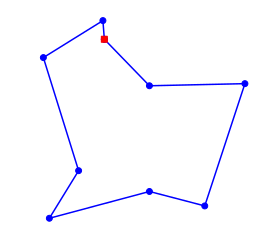

In [8]:
plot_tsp(tsp_alltours, cities(9))

# Approximations

Considering all tours is only feasible for a very limited number of cities. As Norvig points out, simple heuristics can be surprisingly good and are able to handle extremely large problem instances.

In [9]:
def tsp_nn(cities, tour=None):
    if tour == None: tour = [first(cities)]
    unvisited = set(cities - set(tour))
    
    while unvisited:
        nearest_city = nearest_neighbor(tour[-1], unvisited)
        tour.append(nearest_city)
        unvisited.remove(nearest_city)
    
    return tour

def nearest_neighbor(current, collection):
    return min(collection, key=lambda x: distance(current, x))

def tsp_repeated_nn(cities, repetitions=100):
    return min((tsp_nn(cities, [start]) 
                for start in sample(cities, repetitions)), 
               key=tour_length)
               
def sample(population, k, seed=42):
    if k == None or k > len(population):
        return population
    
    random.seed(len(population) * k * seed)
    return random.sample(population, k)


Tour of 9 cities has total length 2261.5084843274626
Took 0.00 seconds


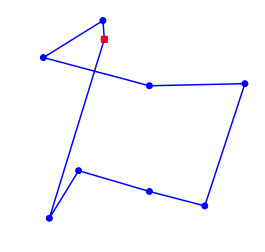

In [10]:
plot_tsp(tsp_nn, cities(9))

Tour of 9 cities has total length 2023.2435500436964
Took 0.00 seconds


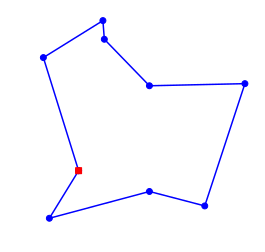

In [11]:
plot_tsp(tsp_repeated_nn, cities(9))

Tour of 200 cities has total length 10363.1597481998
Took 0.01 seconds


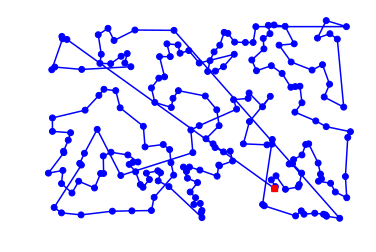

In [12]:
plot_tsp(tsp_nn, cities(200))

Tour of 500 cities has total length 14649.921933409672
Took 5.44 seconds


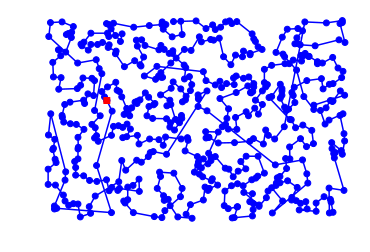

In [30]:
plot_tsp(tsp_repeated_nn, cities(500))

# A* search

The naive algorithm that considers all tours clearly does not scale well.
Maybe we can do (slightly) better by trying segments that look promising first.

What are promising segments? One way to quantify this is to find a lower bound on the tour length
for a segment, and then expand the segment with the lowest bound.
Obviously the segment length itself provides a simple but naive lower bound,
but we can do better. 

Before diving into details, let's look at the big picture.
We keep track of a heap (ordered by the lower bound) of segments,
which we initialize with a trivial segment of a single node.
In fact, we could even start with the empty set and add every single node,
but it is not obvious to me whether that's better or worse.

As long as we haven't found an optimal tour,
we pop the best segment from the heap, and create new segments
by adding an unvisited node to the end.
We can then recompute the lower bound and add this segment to the heap,
and we do this for every unvisited node.
Once all new segments are added, we pop the next best segment from the heap.

At some point we will find a complete tour, which gives us an upperbound on the length of the optimal tour.
Now we only have to consider segments whose lower bound is less than the upperbound, and once we run out of those,
we have found an optimal solution.

We start with a simple PriorityQueue which is based on code provided in Stanford's CS 221 class.

In [31]:
import heapq

class PriorityQueue:
    """ 
    Heap based on code from Stanford CS 221
    
    cs221.stanford.edu
    """
    def  __init__(self):
        self.DONE = -100000
        self.heap = []
        self.priorities = {}  # Map from state to priority

    # Insert |state| into the heap with priority |newPriority| if
    # |state| isn't in the heap or |newPriority| is smaller than the existing
    # priority.
    # Return whether the priority queue was updated.
    def update(self, state, new_priority):
        old_priority = self.priorities.get(state)
        if old_priority == None or new_priority < old_priority:
            self.priorities[state] = new_priority
            heapq.heappush(self.heap, (new_priority, state))
            return True
        return False

    # Returns (state with minimum priority, priority)
    # or (None, None) if the priority queue is empty.
    def pop(self):
        while len(self.heap) > 0:
            priority, state = heapq.heappop(self.heap)
            if self.priorities[state] == self.DONE: continue  # Outdated priority, skip
            self.priorities[state] = self.DONE
            return (state, priority)
        return (None, None) # Nothing left...
    
    def __repr__(self):
        return "PQ {}".format(self.heap)

Tour of 7 cities has total length 1818.6687444623317
Took 0.00 seconds


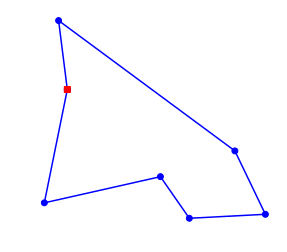

In [32]:
plot_tsp(tsp_alltours, cities(7))

Now let's find a lower bound. 
Clearly the segment length provides a lower bound, but we can do better by noting that for each unvisited city,
we have to add an edge to our current segment that is at least as far away as the closest other city.

There are some refinements possible, for example by noting that for a tour, each city has 2 edges,
so the minimum tour length $T$ is at least as large as
$$
T \ge 1/2 * \sum_{c \in C} d_c(1) + d_c(2)
$$
where $C$ is the set of cities, and $d_c(1)$ is the distance to the closest city from $c$ and $d_c(2)$ is the distance to the second closest city from $c$.

In [18]:
def compute_shortest_distances(nodes):
    return {city: min(distance(city, other) 
                      for other in nodes if other != city) 
            for city in nodes}
    

def segment_length(segment):
    return sum(distance(segment[i-1], segment[i]) for i in range(1, len(segment)))


def lower_bound(nodes):
    shortest_distances = compute_shortest_distances(nodes)
    lb_empty = sum(shortest_distances.values())
    
    def ls(segment, unvisited):
        if len(unvisited) == 0:
            return tour_length(segment)
        return segment_length(segment) + sum(shortest_distances[node] for node in unvisited)
    
    return ls

For debugging, it's useful to be able to plot segments as well.

In [33]:
def plot_segment(cities, segment):
    f, ax = plt.subplots()
    plot_lines(ax, list(segment), style="r.-")
    plot_lines(ax, list(cities), style="bo")
    
    ax.axis('scaled')
    ax.axis('off')

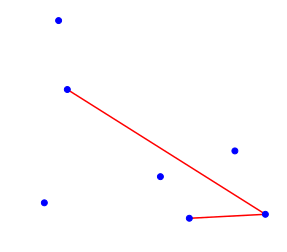

In [34]:
plot_segment(example, list(example)[:3])

Now the meat of the algorithm.
Our algorithm can be seen as a search over a search graph, which is different from the TSP graph.
We define the current state by the segment (a tuple), and unvisited nodes (a frozenset) (which could be computed from the segment as well).
We make sure both of these are immutable so we can hash them.
Furthermore, this helps to avoid bugs.

In [35]:
# state = (segment, unvisited)


# two helper functions to 
def extend_segment(segment, node):
    return segment + (node, )

def remove_fset(collection, element):
    return frozenset(set(collection) - {element})


class TSP_Problem:
    def __init__(self, nodes):
        self.nodes = nodes
        self.lb = lower_bound(nodes)
    
    # use NN to get a crude upperbound
    # nn_tour = tsp_nn(nodes)
    # upper_bound = tour_length(nn_tour)
    
    def initial_state(self):
        start = first(self.nodes)
        return (start, ), remove_fset(self.nodes, start)

    def new_states_and_cost(self, state):
        segment, unvisited = state
        current = segment[-1]
        
        for node in unvisited:
            new_segment = extend_segment(segment, node)
            new_unvisited = remove_fset(unvisited, node)
            yield (new_segment, new_unvisited), self.lb(new_segment, new_unvisited)
            
    def is_goal(self, state):
        _, unvisited = state
        return len(unvisited) == 0
    
def solve_tsp_problem(tsp_problem, max_time=30):    
    queue = PriorityQueue()
    queue.update(tsp_problem.initial_state(), 0)
        
    t_start = time.clock()
    while time.clock() - t_start < max_time:
        state, cost = queue.pop()
        segment, unvisited = state
                
        # if goal achieved, this must be shortest tour
        if len(unvisited) == 0:
            tour, _ = state
            assert abs(cost - tour_length(tour)) < 1e-5, "Lower bound {} does not correspond to tour length {}".format(cost, tour_length(tour))
            return tour            
        
        for new_state, new_cost in tsp_problem.new_states_and_cost(state):
            queue.update(new_state, new_cost)
            
    print("Warning: no optimal solution found")
    return tsp_repeated_nn(tsp_problem.nodes)
            
def tsp_pq(cities):
    tsp_problem = TSP_Problem(cities)
    return solve_tsp_problem(tsp_problem)

Tour of 7 cities has total length 1818.6687444623317
Took 0.01 seconds
Tour of 8 cities has total length 1793.4949761708926
Took 0.04 seconds
Tour of 9 cities has total length 2023.2435500436966
Took 0.07 seconds
Tour of 10 cities has total length 2410.10848560351
Took 0.36 seconds
Tour of 11 cities has total length 2364.447479746751
Took 0.70 seconds
Tour of 12 cities has total length 2088.7415346014814
Took 18.61 seconds


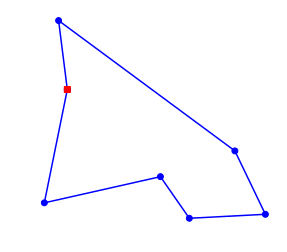

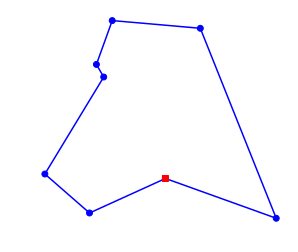

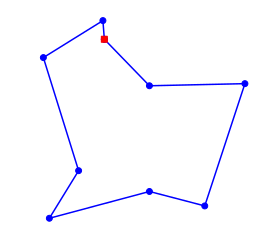

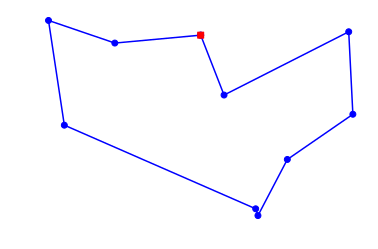

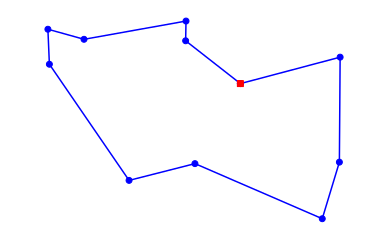

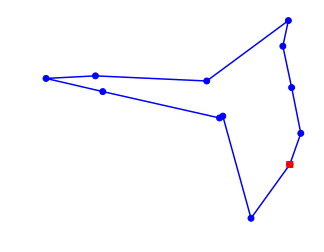

In [41]:
for n in range(7, 13):
    plot_tsp(tsp_pq, cities(n))

We note that we can handle slightly bigger problems now, 
but the gains are small, and we quickly hit the exponential wall.

Potentially, we can improve performance with a tighter lower bound,
but there are simply too many potential tours that need to be checked.

# Branch and bound using LPs

A very successful approach is the branch and bound / branch and cut methods.

One general approach to solving hard problems is to relax! 
In this particular case, we can formulate the TSP as an Integer Linear Program:
For each edge, we create a decision variable $x_e \in \{0, 1\}$ that denotes whether the edge is included in the tour.
Now we have to ensure that each node has exactly 2 adjacent edges.

Unfortunately, there are two problems:
The obvious one is that integer problems are hard.
Furthermore, this does not ensure that we find 2 (or more) disconnected tours (or subtours).
To avoid these, we have to include subtour elimination constraints that make such solutions infeasible.
The problem is that there are exponentially many such constraints.

So how do we relax? First, we let go of the integer condition and solve the LP.
Furthermore, we ignore *all* subtour elimination constraints.
Solving the relaxed LP is easy, and if it returns an integer solution without subtours 
we know we found an optimal solution.

Furthermore, this approach has the benefit of providing us with another lower bound on the optimal value,
which helps quantify how close a given tour is to the optimal tour.

However, we often won't be so lucky, and need to deal with (1) non-integer solutions
and (2) subtours.

To handle non-integer solutions, we use the branch and bound method:
Suppose edge $e$ is "fractionally part of the tour", i.e. $0 < x_e < 1$,
then we branch into two problems: one for which we force $x_e = 0$, and one for which $x_e = 1$,
and find the best one between the two.
Of course we might have to repeat this for multiple such edges.
This explains the branching part.
The bounding part of the algorithm is about pruning the search tree of suboptimal paths.
In particular, if we find a feasible integer solution with value $v$, 
then we can prune all paths where the current lower bound is larger than $v$.
The branching factor is again exponential in the worst case, so there are no guarantees that
this method is faster than the all-tours algorithm.

Given an integer solution, we have to check whether there are any subtours.
If we find a subtour, we add a constraint that prohibits those nodes forming a subtour,
and solve the augmented LP using branch-and-bound again.

Below I've used [cvxpy](www.cvxpy.org) to implement this strategy.
While it is not tailored to LPs, it's intuitive and easy to use.

In [23]:
import cvxpy as cvx
import numpy as np
import collections

In [24]:
def get_solution(problem):
    """
    Helper function to extract (optimal) solution from a problem
    """
    return np.array(problem.variables()[0].value).squeeze()

def find_subtour(solution, edges):
    """
    Function that searches for a (sub)tour in the solution.
    """
    
    # find the edges that are used for the tour
    active_edges = [i for i, v in enumerate(solution) if v > 1-1e-3]

    # find which nodes are connected to create the search tree
    active_nodes_edges = collections.defaultdict(set)
    for e in active_edges:
        a, b = edges[e]
        active_nodes_edges[a].add(b)
        active_nodes_edges[b].add(a)
    
    # find the nodes of the subtour
    to_explore = [a]
    visited = set()
    while to_explore:
        node = to_explore.pop()
        visited.add(node)
        for other in active_nodes_edges[node]:
            if other not in visited:
                to_explore.append(other)
    
    # find the edges of the subtour
    return [e for e in edges if edges[e][0] in visited and edges[e][1] in visited], len(visited)
        

In [45]:
def find_violation(x):
    """
    Find a "fractional" edge
    """
    
    # find the index of the value closest to 0.5
    i = np.argmin(abs(x-0.5))
    # make sure the value is not 0 or 1
    v = min(x[i], 1-x[i])
    if v > 1e-4:
        return i

def branch_and_bound(problem):
    upper_bound = 1e9
    solution = None
    
    # add the initial relaxation
    problems = [(-1e9, problem)]
    while problems:
        lower_bound, p = problems.pop(0)
        
        # if we found a better solution than the lower bound of the current 
        # relaxation, we can ignore this problem
        if lower_bound > upper_bound:
            continue
        
        value = p.solve()        
        if p.status != cvx.OPTIMAL:
            continue
        
        # find fractional edges
        x = get_solution(p)
        violation = find_violation(x)
        
        # check whether we have found a feasible integer solution
        # if so, record it if it is the current best
        if violation == None:
            if value < upper_bound:
                upper_bound = value
                solution = p
        # otherwise we branch on the fractional edge
        # by forcing the edge to be absent and present, respectively
        elif value < upper_bound:
            problems.append((value, 
                             cvx.Problem(p.objective, p.constraints[:] + [p.variables()[0][violation] == 0])))
            problems.append((value, 
                             cvx.Problem(p.objective, p.constraints[:] + [p.variables()[0][violation] == 1])))

    if solution == None:
        print("Warning, no solution found")
    return solution

In [46]:
def plot_solution(problem):
    solution = get_solution(problem)
    active_edges = [i for i, v in enumerate(solution) if v > 1-1e-5]

    f, ax = plt.subplots()

    for i, v in enumerate(solution):
        if v > 1-1e-3:
            plot_lines(ax, edges[i])
        elif v > 1e-3:
            plot_lines(ax, edges[i], style="bo--")

    ax.axis('scaled')
    ax.axis('off')

Let's solve an example with 12 cities.
I also plot the intermediate integer solutions that have subtours 
to visualize the subtour elimination process.

Found subtour of length 3, lower bound 1475
Found subtour of length 9, lower bound 1608
Found subtour of length 6, lower bound 1952
Found subtour of length 4, lower bound 2041
Shortest tour: 1758.28


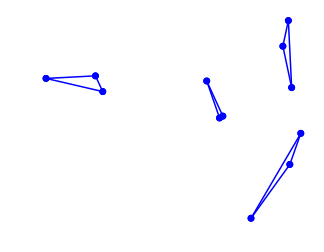

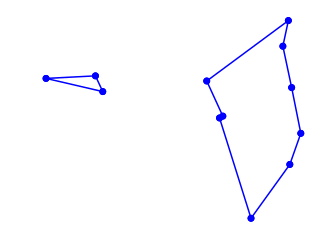

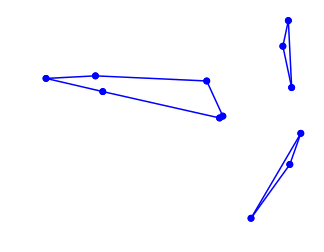

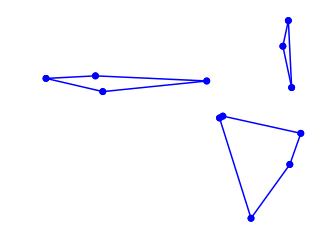

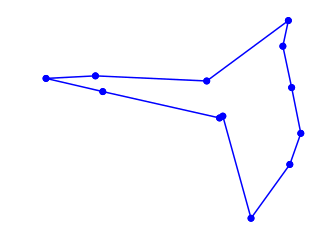

In [48]:
nodes = cities(12)
edges = {i: (a, b) for i, (a, b) in enumerate((a, b) 
                                              for a in nodes for b in nodes 
                                              if a < b)}
node_edges = {node: {i for i, (a, b) in edges.items() 
                     if node == a or node == b} 
              for node in nodes}

m = len(edges)
x = cvx.Variable(m)

edge_cost = np.array([distance(edges[i][0], edges[i][1]) for i in range(m)])
objective = cvx.Minimize(edge_cost * x)

constraints = [x >= 0] + [x <= 1]
for node, indices in node_edges.items():
    u = np.zeros(m)
    u[list(indices)] = 1
    constraints += [(u * x) == 2]

problem = cvx.Problem(objective, constraints)

while True:
    solved_bb = branch_and_bound(problem)
    solved_bb.solve()
    
    plot_solution(solved_bb)
    
    subtour, length = find_subtour(get_solution(solved_bb), edges)
    
    if length == len(nodes):
        break

    print("Found subtour of length {}, lower bound {:.0f}".format(length, solved_bb.value))
    u = np.zeros(m)
    u[subtour] = 1
    constraints += [u * problem.variables()[0] < length-0.5]
    problem = cvx.Problem(objective, constraints)
    
print("Shortest tour: {:.2f}".format(problem.value))

We see that the optimal solution is much shorter than the one found by the repeated nearest neighbor algorithm.

Tour of 12 cities has total length 2137.7095134312626
Took 0.00 seconds


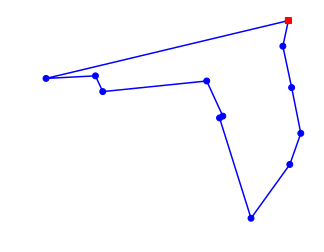

In [44]:
plot_tsp(tsp_repeated_nn, nodes)